In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import subprocess

In [42]:
DATA_DIR = 'data'
BUFFER_SIZE = 256
TRAIN_SIZE = 0.7

# Load data

In [4]:
applauses, applauses_sampling_rate = tf.audio.decode_wav(tf.io.read_file(os.path.join(DATA_DIR, 'applauses.wav')))
music, music_sampling_rate = tf.audio.decode_wav(tf.io.read_file(os.path.join(DATA_DIR, 'music.wav')))

applauses.shape, music.shape, applauses_sampling_rate, music_sampling_rate

(TensorShape([35938304, 2]),
 TensorShape([127437824, 2]),
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>,
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>)

In [5]:
def split_data(d, d_sampling_rate):
    data_size = d.shape[0]
    batch_size = d_sampling_rate // 4 # split into 0.25 second intervals
    batch_count = data_size // batch_size 
    return np.array_split(d[:batch_count * batch_size], batch_count)

In [23]:
applauses_split = split_data(applauses, applauses_sampling_rate)
music_split = split_data(music, music_sampling_rate)

len(applauses_split), len(music_split)

(3259, 11558)

In [26]:
applauses_labels, music_labels = np.ones(len(applauses_split)), np.zeros(len(music_split))

In [33]:
X_unshuffled = applauses_split + music_split
y_unshuffled = np.concatenate((applauses_labels, music_labels), axis=0)

In [50]:
DATA_SIZE = len(X_unshuffled)

# Visualize data

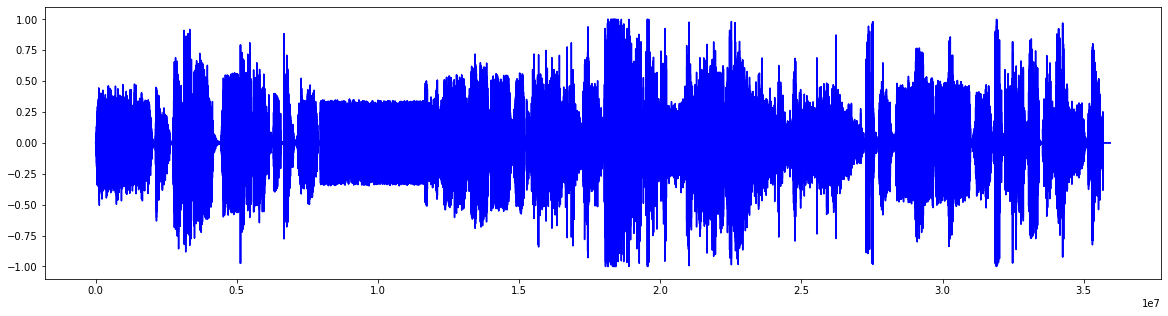

In [20]:
fig = plt.figure(figsize=(20, 5))
plt.plot(applauses, color='blue')

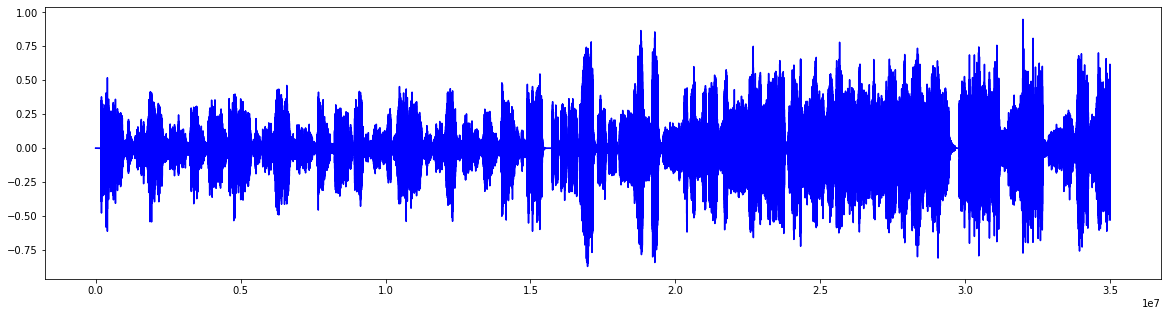

In [22]:
fig = plt.figure(figsize=(20, 5))
plt.plot(music[:35000000], color='blue')

# Cleaning

In [36]:
waveform_dataset = tf.data.Dataset.from_tensor_slices(X_unshuffled)
label_dataset = tf.data.Dataset.from_tensor_slices(y_unshuffled)

In [37]:
dataset = tf.data.Dataset.zip((waveform_dataset, label_dataset))

In [53]:
dataset = dataset.shuffle(DATA_SIZE).prefetch(BUFFER_SIZE)

In [56]:
train_dataset = dataset.take(int(TRAIN_SIZE * DATA_SIZE))
test_dataset = dataset.skip(int(TRAIN_SIZE * DATA_SIZE))

In [64]:
for i in train_dataset.take(10):
    print(i)

(<tf.Tensor: shape=(11025, 2), dtype=float32, numpy=
array([[-0.00891113, -0.01959229],
       [-0.01287842, -0.0262146 ],
       [-0.01641846, -0.03173828],
       ...,
       [ 0.01779175,  0.00363159],
       [ 0.01794434,  0.00302124],
       [ 0.01873779,  0.00262451]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0>)
(<tf.Tensor: shape=(11025, 2), dtype=float32, numpy=
array([[-0.00286865, -0.04534912],
       [-0.00378418, -0.04507446],
       [-0.00445557, -0.04418945],
       ...,
       [-0.00576782, -0.00964355],
       [-0.00888062, -0.01055908],
       [-0.01211548, -0.01211548]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0>)
(<tf.Tensor: shape=(11025, 2), dtype=float32, numpy=
array([[-0.02859497, -0.0953064 ],
       [-0.03393555, -0.09088135],
       [-0.034729  , -0.06399536],
       ...,
       [ 0.02279663,  0.04653931],
       [ 0.01150513,  0.04568481],
       [ 0.00518799,  0.03274536]], dtype=float32)>, <tf.Tensor: shape=(), d